<h1 align="center"><font size="8">How to win a Clan War with Statistics</font><br><font size="5">an in-depth Clash of Clans Clan War analysis by Gregory Ho<br>Published May 2022</font> </h1>

## Table of Contents
1. [Introduction](#introduction)
2. [Connect to Clash of Clans API](#connect)
3. [Collect Clan War data](#collect)
4. [Convert Clan War Log to dataframe](#convert)
5. [Analysis](#analysis)
---

## Introduction <a id="introduction"></a>
### The Problem
From a serious Clash of Clans war-goer to a casual weekend Clash of Clans war player, being able to bring out the best of your clan to perform in war has always been the goal. Thus, every clan leader has their own way of enforcing the discipline of their clan, whether it is requesting donations only as much as you donate or requiring hero levels to be above a certain threshold.  <br>

For smaller clans of some 10-15 members, enforcing the clan is certainly manageable, however, it scales poorly when that size suddenly drives up to 40+ members. The task of managing each individual member on a regular basis becomes a menial task when using the game interface to find and extract information from each member's profile. And when that is further scaled up to estimating the strength of the enemy clan by going through each of *their* 40+ member profiles, clan management becomes unmanageable. This is where the Clash of Clans API is able to cover for.  <br>

### The Solution
The Clash of Clans (CoC) API provides detailed information regarding a player's statistics, clan information, and clan war information, which could not be easily collected en masse in-game.  
This notebook is meant to provide a simple tutorial of the possibilities allowed by the API.  <br>

In order to connect to the API, we need to register a CoC developer account and make requests with JSON web tokens via API keys. Fortunately, this process is made easier with an existing repository which handles the keys and tokens for us, allowing us to connect to the client only requiring a developer account. We may then proceed to collect various datapoints on such as donations made by specific players, clan-wide hero levels, and the various wins and losses against other clans in war.  <br>

Here, we will attempt to discover the factors that influence the result of winning a war against an opponent clan through calculating metrics such as average hero levels for the first 15 players in war. These discoveries will especially reveal greater insight into the hidden factors that may influence the outcome of a clan war.  
Afterwards, we can also build a classifier for estimating the likelihood of winning a war given certain attributes of the clan, so predictions may be made to whether a war can be won or not.

### Import libraries and packages
The first 3 imports allows us to use the coc.py package to connect to the CoC API without worrying about tokens or API keys. The fourth import contains customized utility functions for parsing data from the coc.py package

The next 3 imports allow us to more easily parse data coming from the API. coc_utils uses these imports

The next group of imports is involved in data transformation and visualization after collecting the appropriate data in a readable format. sklearn is also provided to estimate parameter correlation with war results.

The final group of imports deal with formatting and output data in each code block

In [1]:
import coc
import asyncio
import nest_asyncio
import coc_utils

import re
from bs4 import BeautifulSoup as bs4
import datetime

import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro
import sklearn
from sklearn.svm import SVC

from IPython.display import clear_output
import time
import pprint

---

## Connect to Clash of Clans API <a id="connect"></a>
With the coc.py package provided by mathsman5133 at https://github.com/mathsman5133/coc.py, connecting to the Clash of Clans API becomes easier. \
Normally, the Clash of Clans API requires a Clash of Clans developer account, JSON web token, as well as the public IP address port to release data to. \
This package handles the token authentications only requiring the Clash of Clans developer account authentication information. \
The data is then able to be collected asynchronously via the coc.py package.
### Login Information
A Clash of Clans developer account can be made at https://developer.clashofclans.com/ \
The provided email and password credentials used here were created specifically for this notebook, but your own developer account may be provided for your own use.

Create an auth.txt file in this directory. Put your email on the first line and your password on the second line.

In [2]:
fp = open('auth.txt', 'r')
lines = fp.readlines()

email = lines[0]
pwd = lines[1]

### Connection Request
asyncio is a required package of coc.py, and nest_asyncio is required to run the nested asynchronous tasks in coc.py \
After these requirements are met, login to the developer client through coc.login()

In [3]:
nest_asyncio.apply()
client = coc.login(email, pwd)

This client allows us to run coroutines of gathering data from each task.  
Some of the actions include searching for clans and getting the current war data if any in addition to retrieving individual player and clan data.

---

## Collect Clan and Player data <a id="collect"></a>
After logging in, we can start collecting Clash of Clans data. Like in the game, the player tag and clan tag serve as unique identifiers for their player and clan, so it should be provided 
### Set player and clan tags
Here, my personal player tag and clan tag is used to pull my player and clan information from, but it is recommended that your own account information may be provided for your own use.

In [4]:
player_tag = "#JYLP2PJG"
clan_tag = "#20VLL8222"

### Sample Player & Clan Info
From coc_utils, we can sample some info from the given player and clan tags by using the customized utility functions to pull the data from the client  
The utility functions return a dictionary of the attributes of the player/clan except for get_warlog_info which returns a list of dictionaries of the attributes for each war

In [5]:
player_info = await coc_utils.get_player_info(client, player_tag)   
# print(player_info)

This function requires the client from coc.py and a player tag ID. Additionally, a parameter limit may be provided for which metrics to not include in the player data  
get_player_info(client, player_tag, limit=\['achievements','load_game_data','builder_hall','builder_troops'\])  
Data:  
- Attack Wins
- Best Trophies
- Best Versus Trophies
- Clan
- Clan Previous Rank
- Clan Rank
- Defense Wins
- Donations
- Experience Level
- Troop Levels
- Hero Levels
- Pet Levels
- Spell Levels
- Siege Machine Levels
- Trophies (Current)
- Versus Attack Wins
- Versus Trophies (Current)
- Opted in War?
- War Stars

We are also able to sample the clan data as well as the detailed information on each member in the clan by indicating detailed=True<br>
The output here is omitted here because of the large amount of information to note  
(omit_members is used to omit outputting the list of members in the clan as an attribute)

In [6]:
# Detailed also adds individual member data to the provided query
clan_info = await coc_utils.get_clan_info(client, clan_tag, detailed=True, omit_members=True)
# print(clan_info)

get_clan_info(client, clan_tag, detailed=False, omit_members=False)  
Data:
- Chat Language
- Description
- Labels 1,2,3
- Level
- Location
- Number of Members
- Clan Name
- Clan Points
- Is war log public?
- Required trophies to join
- Share Link
- Clan Tag
- Invitation Setting
- Clan Versus Points
- War Frequency
- War League
- War wins, losses, ties
- War win streak


And if detailed:  
- Attack wins of every member
- Best trophies of every member
- Donations of every member
- Troop/Spell/Hero/Pet levels of every member
- Town Hall level of every member
- Legend Trophies of every member
- Trophies of every member (current)
- Number of members opting in for war

If the clan tag is not provided, you can also search for various clans by name as well

In [7]:
multiple_clan_info = []
clans = await client.search_clans(name="Yeet",limit=5)
for clan in clans:
    multiple_clan_info.append(await coc_utils.get_clan_info(client, clan.tag, detailed=False, omit_members=True))

yeet_df = pd.DataFrame(multiple_clan_info)
yeet_df

,chat_language,description,labels,level,location,member_count,name,points,public_war_log,required_trophies,share_link,tag,type,versus_points,war_frequency,war_league,war_losses,war_ties,war_win_streak,war_wins
0,English,War Perfecting Clan. War Attack Style: YEET. N...,"[Clan Wars, Clan War League, Donations]",17,Australia,48,Yeet,40671,True,3000,https://link.clashofclans.com/en?action=OpenCl...,#20VLL8222,inviteOnly,41388,always,Crystal League I,176,1,0,239
1,None,DANISH CLAN :) Velkommen til Yeet dette er en ...,"[Clan Wars, Donations, Friendly]",5,Denmark,35,Yeet,18474,True,1500,https://link.clashofclans.com/en?action=OpenCl...,#2889GUQCL,inviteOnly,18610,always,Gold League I,18,0,1,21
2,Nederlands,,"[Donations, Friendly, Competitive]",2,None,10,yeet,8083,False,0,https://link.clashofclans.com/en?action=OpenCl...,#2LJL9YQLP,inviteOnly,7560,unknown,Unranked,None,None,0,3
3,Deutsch,Deutschland🇩🇪🇩🇪🇩🇪🇩🇪🇩🇪🇩🇪 Afk= Kick,"[International, Donations, Competitive]",7,International,46,Yeet,22539,True,1800,https://link.clashofclans.com/en?action=OpenCl...,#2L200RG9C,open,24636,always,Gold League III,60,1,0,62
4,Deutsch,"Keine Knechte und Geringverdiener, Hoher Natri...","[Farming, Friendly, Underdog]",4,Germany,10,Yeet,7329,False,0,https://link.clashofclans.com/en?action=OpenCl...,#2LLLLJ28J,closed,8190,always,Unranked,None,None,2,33


Here, we were able to sample some information from player/clan data, now let's start finding the player/clan data on every opponent we've faced in war on record

---

## Convert Clan War Log to Dataframe <a id="convert"></a>
So we are able to sample information from both a player and a clan given the player tag and clan tag. Now, it would be more useful to gather data on each of the players and clans that we face against in the wars stored in our war logs. Below, we will collect all of the information on each war stored in a clan's war log (up to when CoC removes the war history) including information gathered by calling get_player_info and get_clan_info  
Then, create the dataframe with each entry as an individual war  
*Note: Loading all the war log data will take a while*

In [8]:
war_log_info = await coc_utils.get_warlog_info(client, clan_tag, clan_details=True)

Wars 118 of 118 finished logging


### Helper functions
Below are helper methods for finding the cumulative sum of the highest N numbers of any list of data containing information on each member (such as attack wins for every member)

In [9]:
# For each row in cumsum_arr and N_arr, retrieve array data from row in cumsum_arr and take the cumulative sum of the first n numbers in N_arr
def cumulative_sum_N(cumsum_arr, N_arr):
    cumulative_sums = cumsum_arr.apply(lambda x: np.nancumsum(x)).to_numpy()
    a = []
    for idx, size in enumerate(N_arr.values):
        a.append(cumulative_sums[idx][np.minimum(np.maximum(0,len(cumulative_sums[idx])-1),size)]) if len(cumulative_sums[idx]) > 0 else a.append(None)
    return pd.Series(a)

# Take the cumulative sum of the first n numbers for each array in cumsum_arr
def cumulative_sum(cumsum_arr, n):
    cumsum_arr.apply(lambda x: np.cumsum(x)[n-1])

### Convert log to dataframe
The formatted output of coc_utils' get_warlog_info is able to be directed converted to a pandas dataframe

In [10]:
df = pd.DataFrame(war_log_info)

### Data Calculations
Now, we can start tidying up the data by adding additional metrics and removing unnecessary data.  
We can use our helper functions to calculate the sum of the total member attack wins from the top n members of the clan

In [13]:
df = pd.DataFrame(war_log_info)

df = df.replace('None', np.NaN)

# Aggregate sum metrics
df['top_member_attack_wins'] = cumulative_sum_N(df['member_attack_wins'], df['team_size'])
df['avg_member_attack_wins'] = df['top_member_attack_wins']/df['team_size']

df['top_best_trophies'] = cumulative_sum_N(df['best_trophies'], df['team_size'])
df['avg_best_trophies'] = df['top_best_trophies']/df['team_size']

df['top_donations'] = cumulative_sum_N(df['donations'], df['team_size'])
df['avg_donations'] = df['top_donations']/df['team_size']

df['top_war_stars'] = cumulative_sum_N(df['war_stars'], df['team_size'])
df['avg_war_stars'] = df['top_war_stars']/df['team_size']

df['top_king_lvls'] = cumulative_sum_N(df['barbarian_king'],df['team_size'])
df['avg_king_lvl'] = df['top_king_lvls']/df['team_size']
df['top_queen_lvls'] = cumulative_sum_N(df['archer_queen'],df['team_size'])
df['avg_queen_lvl'] = df['top_queen_lvls']/df['team_size']
df['top_warden_lvls'] = cumulative_sum_N(df['grand_warden'],df['team_size'])
df['avg_warden_lvl'] = df['top_warden_lvls']/df['team_size']
df['top_rc_lvls'] = cumulative_sum_N(df['royal_champion'],df['team_size'])
df['avg_rc_lvl'] = df['top_rc_lvls']/df['team_size']

df['top_legend_trophies'] = cumulative_sum_N(df['legend_trophies'],df['team_size'])
df['avg_legend_trophies'] = df['top_legend_trophies']/df['team_size']

# Difference metric
df['level_difference'] = df['clan_level'] - df['opponent_level']
df['destruction_difference'] = df['clan_destruction'] - df['opponent_destruction']
df['star_difference'] = df['clan_stars'] - df['opponent_stars']


# Rates metric
df['attack_rate'] = df['clan_attacks_used']/df['clan_total_attacks']
df['opponent_win_rate'] = df['war_wins']/(df[['war_wins','war_ties','war_losses']].sum(numeric_only=True, axis=1))

### Data Tidying
We will also remove redundant columns or columns which have missing data  
The result metric will also be mapped from categorical wins and losses to 1s and 0s  
The war league metric which will be mapped to the order of league ranking by number from Bronze League III to Titan League I and Legend League

In [16]:
df = df.drop(columns = ['opponent_max_stars','opponent_total_attacks']) # Same as clan_max_stars
df = df.rename(columns = {'clan_max_stars': 'max_stars'})
col = df.pop("result")
df.insert(len(df.columns), col.name, col)

# Map a number for each clan league in war league
league_map = {'Bronze League III': 0,
              'Bronze League II': 1,
              'Bronze League I': 2,
              'Silver League III': 3,
              'Silver League II': 4,
              'Silver League I': 5,
              'Gold League III': 6,
              'Gold League II': 7,
              'Gold League I': 8,
              'Crystal League III': 9,
              'Crystal League II': 10,
              'Crystal League I': 11,
              'Master League III': 12,
              'Master League II': 13,
              'Master League I': 14,
              'Champion League III': 15,
              'Champion League II': 16,
              'Champion League I': 17,
              'Titan League III': 18,
              'Titan League II': 19,
              'Titan League I': 20,
              'Legend League': 21}

df['war_league_map'] = df['war_league'].apply(lambda x: league_map[x])

# Map 1s for every win in result
df['result_map'] = df['result'].map({'win': 1, 'lose': 0})

df = df.dropna(subset=['result','clan_destruction','opponent_destruction', 'war_wins'])

df

,clan_attacks_used,clan_destruction,clan_exp_earned,clan_level,max_stars,clan_stars,clan_total_attacks,end_time,opponent_destruction,opponent_level,...,top_legend_trophies,avg_legend_trophies,level_difference,destruction_difference,star_difference,attack_rate,opponent_win_rate,result,war_league_map,result_map
0,22,85.666664,190,17,45,36,45,2022-05-15 02:35:24,86.800000,13,...,1393.0,92.866667,4,-1.133336,0,0.488889,0.537931,lose,12,0
1,24,91.600000,244,17,45,38,45,2022-05-13 03:23:55,83.600000,17,...,7511.0,500.733333,0,8.000000,3,0.533333,0.358811,win,11,1
2,10,76.900000,129,17,30,18,30,2022-04-27 06:26:59,93.200000,20,...,4158.0,415.800000,-3,-16.300000,-7,0.333333,1.000000,lose,11,0
3,13,99.300000,183,17,30,29,30,2022-04-25 04:18:56,74.900000,14,...,0.0,0.000000,3,24.400000,7,0.433333,1.000000,win,8,1
4,16,80.600000,176,17,45,32,45,2022-04-20 04:35:29,85.133330,23,...,14531.0,968.733333,-6,-4.533330,-7,0.355556,1.000000,lose,12,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,23,82.266670,211,15,45,37,45,2021-04-29 05:01:08,91.066666,18,...,968.0,64.533333,-3,-8.799996,1,0.511111,1.000000,win,8,1
97,34,89.750000,243,15,60,50,60,2021-04-26 03:56:57,61.050000,18,...,3796.0,189.800000,-3,28.700000,19,0.566667,0.405714,win,10,1
98,22,89.733330,216,15,45,37,45,2021-04-23 06:51:55,74.133330,15,...,0.0,0.000000,0,15.600000,7,0.488889,1.000000,win,8,1
99,24,88.133330,161,15,45,36,45,2021-04-21 03:40:06,87.066666,17,...,0.0,0.000000,-2,1.066664,-3,0.533333,0.532138,lose,9,0


## Analysis <a id="analysis"></a>
After successfully importing the data, we can begin to run analysis with the dataframe. More specifically, we are looking to find the effect and correlation of parameters on the war result
### Parameter Correlation
Here we can display the correlation of each parameter with the war result

In [17]:
df.corr()['result_map']

clan_attacks_used         0.021525
clan_destruction          0.532464
clan_exp_earned           0.456106
clan_level               -0.164137
max_stars                -0.053940
clan_stars                0.164940
clan_total_attacks       -0.053940
opponent_destruction     -0.463172
opponent_level           -0.100628
opponent_stars           -0.367129
team_size                -0.053940
level                    -0.118597
member_count             -0.127981
points                   -0.113134
required_trophies        -0.036043
versus_points            -0.113019
war_losses                0.169503
war_ties                 -0.131119
war_win_streak           -0.134005
war_wins                 -0.195339
total_war_opted_in       -0.114891
top_member_attack_wins   -0.073575
avg_member_attack_wins   -0.058511
top_best_trophies        -0.087744
avg_best_trophies        -0.088146
top_donations            -0.092149
avg_donations            -0.082280
top_war_stars            -0.182654
avg_war_stars       

We will also sort these correlation values by absolute value to determine the most impactful driving conditions for winning the war  
From this, we can determine that the most impactful parameters are star difference, destruction difference, war league map, and war wins (clan exp earned is a result received after winning or losing a war).

In [18]:
df.corr()['result_map'].abs().sort_values(ascending=False).drop('clan_exp_earned')[1:]

star_difference           0.658874
destruction_difference    0.625450
clan_destruction          0.532464
opponent_destruction      0.463172
opponent_stars            0.367129
war_league_map            0.237141
war_wins                  0.195339
top_war_stars             0.182654
war_losses                0.169503
avg_war_stars             0.168421
clan_stars                0.164940
clan_level                0.164137
top_legend_trophies       0.140459
war_win_streak            0.134005
attack_rate               0.131816
war_ties                  0.131119
member_count              0.127981
avg_legend_trophies       0.124869
level                     0.118597
total_war_opted_in        0.114891
points                    0.113134
versus_points             0.113019
opponent_level            0.100628
top_donations             0.092149
avg_best_trophies         0.088146
top_best_trophies         0.087744
avg_donations             0.082280
top_queen_lvls            0.079433
avg_queen_lvl       

### Clan Star/Destruction vs. Opponent Star/Destruction
Let us start by finding the star difference between the clan and the opponent and plotting their relative density  
This illustrates that the difference tends to be around zero regardless of the team size

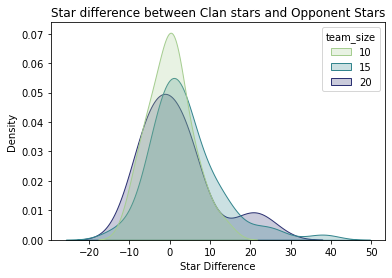

In [19]:
sns.kdeplot(data=(df[(df['team_size'] > 5) & (df['team_size'] < 25)]), x='star_difference', hue='team_size', fill=True, common_norm=False, palette = 'crest');
plt.xlabel('Star Difference')
plt.title('Star difference between Clan stars and Opponent Stars');

Here we plot the rate of destruction each side has while also including whether they win or lose.  
We can then find the relationship between clan destruction and opponent destruction while grouping by the team size of the war that is queued  
It can be seen that there is some relationship between having enough clan destruction over opponent destruction to win the war.  

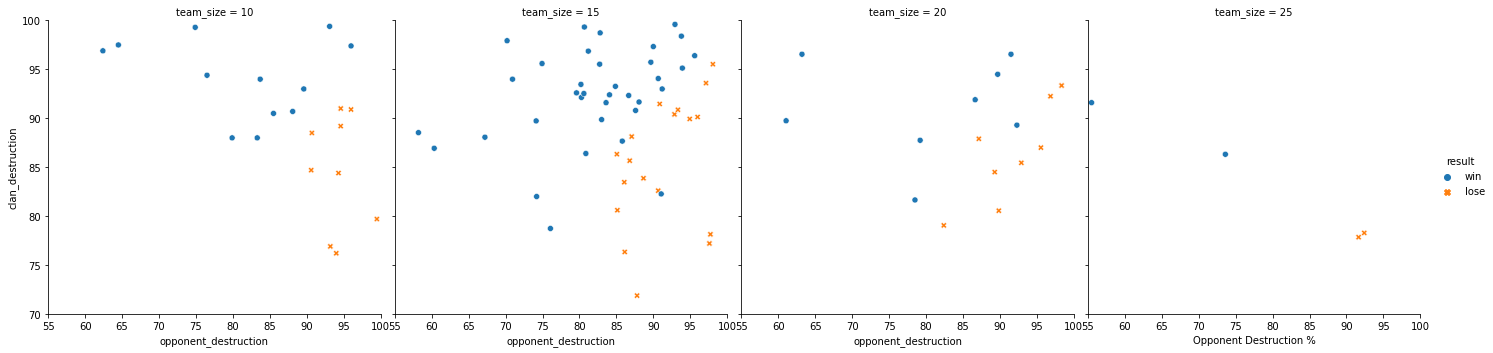

In [20]:
sns.relplot(
    data=df[df['team_size'] > 5],
    x="opponent_destruction", y="clan_destruction", col="team_size",
    hue="result", hue_order=df['result'].unique()[::-1], style="result", style_order=df['result'].unique()[::-1],
)
plt.xlabel('Opponent Destruction %')
plt.ylabel('Clan Destruction %')
plt.xlim(55,100)
plt.ylim(70,100);

We will also plot the total comparison regardless of team size as well

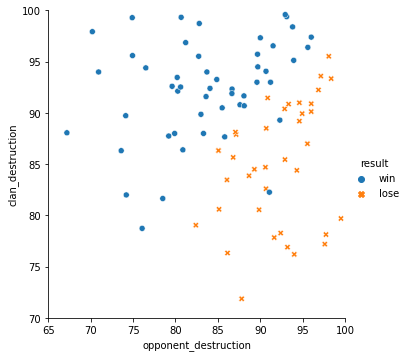

In [21]:
sns.relplot(
    data=df[df['team_size'] > 5],
    x="opponent_destruction", y="clan_destruction",
    hue="result", hue_order=df['result'].unique()[::-1], style="result", style_order=df['result'].unique()[::-1],
)
plt.xlim(65,100)
plt.ylim(70,100);

### Linear Classification
Let us test to find a boundary which is able to classify wins and losses for the stars received by both clans
Since clan stars is the main method by which the winner of the clan war is determined, it should be expected that the classifier will be a linear model

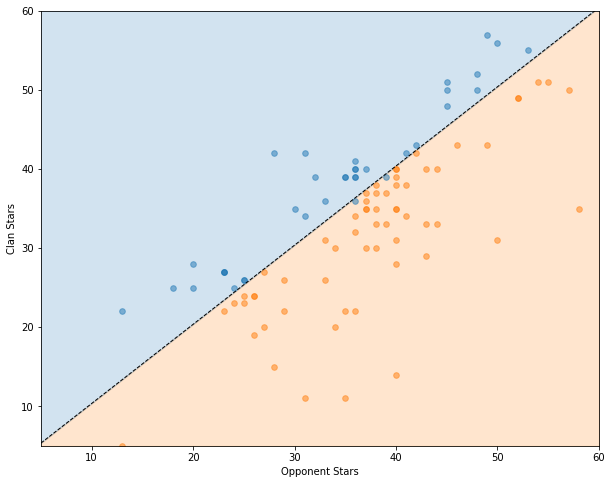

In [22]:
X = np.asarray(list(zip(df.clan_stars,df.opponent_stars)))
y = np.asarray(df['result'].map({'win': 1, 'lose': 0}))

# Fit the data to a logistic regression model.
clf = sklearn.linear_model.LogisticRegression()
clf.fit(X, y)

plt.figure(figsize=(10, 8))

# Retrieve the model parameters.
b = clf.intercept_[0]
w1, w2 = clf.coef_.T
# Calculate the intercept and gradient of the decision boundary.
c = -b/w2
m = -w1/w2

# Plot the data and the classification with the decision boundary.
xmin, xmax = 5, 60
ymin, ymax = 5, 60
xd = np.array([xmin, xmax])
yd = m*xd + c
plt.plot(xd, yd, 'k', lw=1, ls='--')
plt.fill_between(xd, yd, ymin, color='tab:orange', alpha=0.2)
plt.fill_between(xd, yd, ymax, color='tab:blue', alpha=0.2)

plt.scatter(*X[y==0].T, s=32, alpha=0.5)
plt.scatter(*X[y==1].T, s=32, alpha=0.5)
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.ylabel('Clan Stars')
plt.xlabel('Opponent Stars')

plt.show()

Let us also use a linear regression model to determine the boundary between winning vs. losing the war via clan destruction  
We use a linear model here because of the influence of having more clan destruction is one of the tie breaking methods of determining the winner of a war, so we aim to find an approximate boundary for which we can estimate how much destruction we should aim for in war in order to win

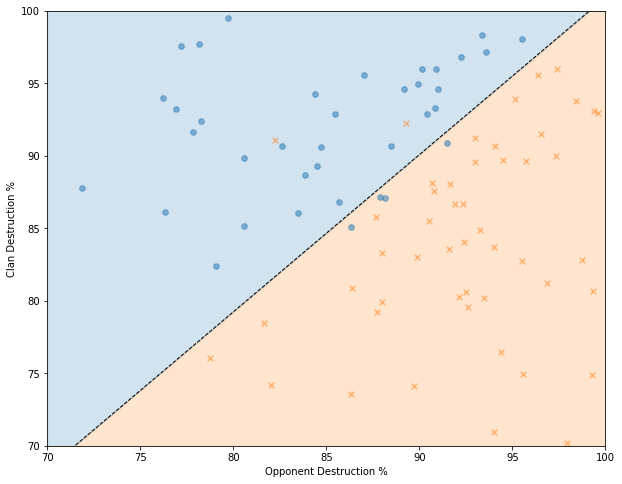

In [23]:
X = np.asarray(list(zip(df.clan_destruction,df.opponent_destruction)))
y = np.asarray(df['result'].map({'win': 1, 'lose': 0}))

# Fit the data to a logistic regression model.
clf = sklearn.linear_model.LogisticRegression()
clf.fit(X, y)

plt.figure(figsize=(10, 8))

# Retrieve the model parameters.
b = clf.intercept_[0]
w1, w2 = clf.coef_.T
# Calculate the intercept and gradient of the decision boundary.
c = -b/w2
m = -w1/w2

# Plot the data and the classification with the decision boundary.
xmin, xmax = 70, 100
ymin, ymax = 70, 100
xd = np.array([xmin, xmax])
yd = m*xd + c
plt.plot(xd, yd, 'k', lw=1, ls='--')
plt.fill_between(xd, yd, ymin, color='tab:orange', alpha=0.2)
plt.fill_between(xd, yd, ymax, color='tab:blue', alpha=0.2)

plt.scatter(*X[y==0].T, s=32, alpha=0.5, marker='o')
plt.scatter(*X[y==1].T, s=32, alpha=0.5, marker='x')
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.ylabel('Clan Destruction %')
plt.xlabel('Opponent Destruction %')

plt.show()

Here, we will also look at the correlation between the opponent's war league map and their war wins as well. Since both these parameters are one of the driving factors behind the war result, there may exist a relationship between these two parameters as well  
However after plotting these parameters, there does not appear to be a clear relationship or reliable classifier between these parameters.  
It may be because the distribution of war wins for a clan is normally distributed.

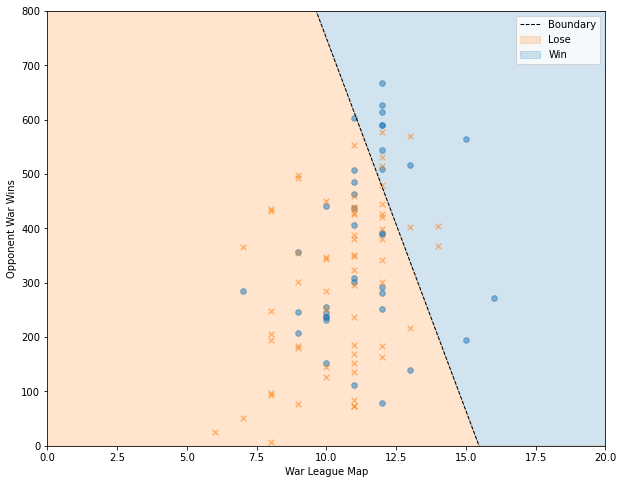

In [24]:
X = np.asarray(list(zip(df.war_league_map,df.war_wins)))
y = np.asarray(df['result'].map({'win': 1, 'lose': 0}))

# Fit the data to a logistic regression model.
clf = sklearn.linear_model.LogisticRegression()
clf.fit(X, y)

plt.figure(figsize=(10, 8))

# Retrieve the model parameters.
b = clf.intercept_[0]
w1, w2 = clf.coef_.T
# Calculate the intercept and gradient of the decision boundary.
c = -b/w2
m = -w1/w2

# Plot the data and the classification with the decision boundary.
xmin, xmax = 0, 20
ymin, ymax = 0, 800
xd = np.array([xmin, xmax])
yd = m*xd + c
plt.plot(xd, yd, 'k', lw=1, ls='--')
plt.fill_between(xd, yd, ymin, color='tab:orange', alpha=0.2)
plt.fill_between(xd, yd, ymax, color='tab:blue', alpha=0.2)

plt.scatter(*X[y==0].T, s=32, alpha=0.5, marker='o')
plt.scatter(*X[y==1].T, s=32, alpha=0.5, marker='x')
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.ylabel('Opponent War Wins')
plt.xlabel('War League Map')
plt.legend(['Boundary','Lose', 'Win'])

plt.show()

### Testing for Gaussian Distribution
From the previous assumption of war wins being normally distributed, we can test for this by using the Shapiro-Wilk Normality test to test for this Gaussian assumption.  
In this case, since the p > 0.05, the likelihood of war wins being normally distributed is higher than the likelihood of it not being normally distributed

In [25]:
stat, p = shapiro(df.war_wins)
is_gaussian = True if p > 0.05 else False
stat, p, is_gaussian

(0.9816934466362, 0.17481772601604462, True)

## Conclusion
From this analysis, it can be clear the importance of knowing the information which drives the result of winning or losing clan wars. For the manager of the clan, it becomes easier to test for these parameters and be able to make various conclusions about why a certain war was won or how the next war against a Master League III war league clan could be won. I think that these tools are especially useful for gathering data on clan information extremely quickly, and this notebook serves to guide by showing how the Clash of Clans API might be used to for the purposes of improving the clans of the users who run these analyses.